In [1]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon

VCFPATH="/storage/s1saini/hipstr_rerun/"
HIPREF="/storage/resources/dbase/human/hs37d5/GRCh37.hipstr_reference.bed"
HRUN="/storage/resources/dbase/human/hg19/hg19.hipstr_reference_hrun.bed"
TMPPATH="/storage/mgymrek/ssc-imputation/tmp"
OUTPATH="pdfs/"

colors = ["gray","red","gold","blue","green","purple"]

hipstr = pd.read_csv(HIPREF, sep="\t", names=["chrom","start","end","period","score","name"])
hipstr = hipstr[hipstr["chrom"].apply(lambda x: x not in ["X","Y"])]
hipstr["chrom"] = hipstr["chrom"].apply(str)

MINLOB = 300 # Min number of 1000G calls to include in heterozygosity comparison
MAXMEANDIFF=20
MAXHRUN = 10

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Preprocess VCFs

In [2]:
header = ["chrom","start","end","AN","period","pgeom","up","down","bpdiffs","AC","NFILT","NSKIP","DFLANKINDEL","DP","DSTUTTER"]
locstats = pd.read_csv(os.path.join(TMPPATH, "locus_stats.tab"), names=header, sep="\t")
locstats["chrom"] = locstats["chrom"].apply(str)
locstats = pd.merge(hipstr, locstats, on=["chrom","start","end","period"], how="left")
locstats.ix[np.isnan(locstats["AN"]), "AN"] = 0
locstats["numcalls"] = locstats["AN"].apply(lambda x: int(x)/2)
locstats["length"] = locstats["end"]-locstats["start"]+1
hrun = pd.read_csv(HRUN, sep="\t", names=["chrom","start","end","period","hrun"])
hrun["chrom"] = hrun["chrom"].apply(lambda x: x[3:])
locstats = pd.merge(hrun[["chrom","start","hrun"]], locstats, on=["chrom","start"])

In [6]:
sampstats = pd.read_fwf(os.path.join(TMPPATH, "sample_stats.tab"), names=["numloci","sample"])
sampstats = sampstats.groupby("sample", as_index=False).agg({"numloci": np.sum})

In [8]:
hiphet = pd.read_csv(os.path.join(TMPPATH, "het_stats.tab"), sep="\t",
                                  names=["chrom","start","end","num_alleles_length","num_alleles","het_ssc_length","het_ssc"])
hiphet["length"] = hiphet["end"]-hiphet["start"]+1
hiphet["chrom"] = hiphet["chrom"].apply(str)

# Scratch - HWE

In [5]:
hwe_header = ["chrom","start","obs_het","obs_hom","exp_het","exp_hom","num_alleles"]
hwe =  pd.read_csv(os.path.join(TMPPATH, "hwe_stats.tab"), names=hwe_header, sep="\t")
hwe["perc.het.obs"] = hwe.apply(lambda x: x["obs_het"]*1.0/(x["obs_het"]+x["obs_hom"]), 1)
hwe["perc.het.exp"] = hwe.apply(lambda x: x["exp_het"]*1.0/(x["exp_het"]+x["exp_hom"]), 1)
hwe.head()

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


,chrom,start,obs_het,obs_hom,exp_het,exp_hom,num_alleles,perc.het.obs,perc.het.exp
0,10,65899,111,838,131.155427,817.844573,4,0.116965,0.138204
1,10,68735,205,692,221.839465,675.160535,5,0.228540,0.247313
2,10,87431,0,530,0.000000,530.000000,1,0.000000,0.000000
3,10,88504,0,1906,0.000000,1906.000000,1,0.000000,0.000000
4,10,90603,0,655,0.000000,655.000000,1,0.000000,0.000000


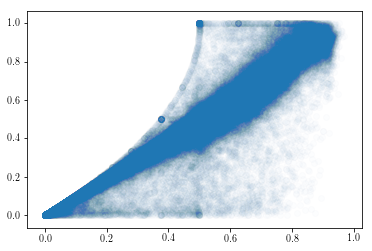

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(hwe["perc.het.exp"], hwe["perc.het.obs"], alpha=0.01);

# Scratch - checking for batch artifacts
Move after we resolve these issues

In [7]:
BATCHSIZE=500
# Calculate batch number
locstats["num"] = -1
for chrom in range(1, 23):
    numchrom = locstats[locstats["chrom"].apply(str)==str(chrom)].shape[0]
    locstats.ix[locstats["chrom"].apply(str)==str(chrom),"num"] = range(numchrom)
locstats["batchnum"] = locstats.apply(lambda x: str(x["chrom"])+"_"+str(int(x["num"]/BATCHSIZE)), 1)
batches = locstats.groupby("batchnum", as_index=False).agg({"numcalls": np.mean,"chrom":len})
#batches.sort("numcalls").to_csv("batch_stats.csv", index=False)

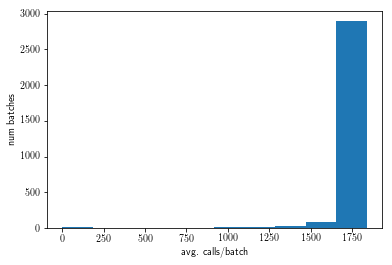

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(batches[batches["chrom"]==BATCHSIZE]["numcalls"]);
ax.set_xlabel("avg. calls/batch")
ax.set_ylabel("num batches");

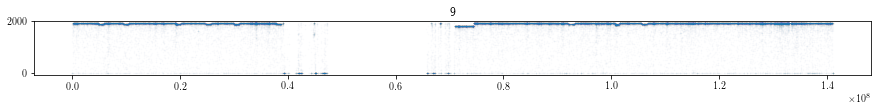

In [9]:
chrom = 9
fig = plt.figure()
fig.set_size_inches((15, 1))
ax = fig.add_subplot(111)
x = locstats[locstats["chrom"].apply(str)==str(chrom)]
ax.scatter(x["start"], x["numcalls"], alpha=0.01, s=1);
ax.set_title(chrom);

# Call rate per locus

In [6]:
# Overall call rate
1-locstats[locstats["numcalls"]==0].shape[0]/locstats.shape[0]

0.9675764096344832

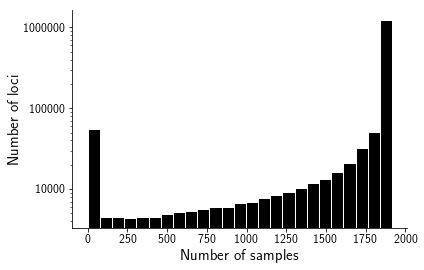

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(locstats["numcalls"], log=True, color="black", edgecolor="white", bins=25);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of samples", size=15)
ax.set_ylabel("Number of loci", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure1_SamplesPerLocus.png"))

# Length bias

In [12]:
def GetMeanDiff(x):
    total_alleles = x["AN"]
    total_diff = 0
    if total_alleles == 0: return 0
    if x["AC"]==".": return 0
    alts = x["bpdiffs"].split(",")
    counts = x["AC"].split(",")
    for i in range(len(alts)):
        total_diff += int(alts[i])*int(counts[i])
    return total_diff*1.0/total_alleles

locstats["length"] = locstats["end"]-locstats["start"]+1
locstats["meandiff"] = locstats.apply(GetMeanDiff, 1)

In [13]:
reflen = range(10, 100, 1)
diffs = []
percs = []
for i in range(len(reflen)-1):
    lb = reflen[i]
    ub = reflen[i+1]
    x = locstats[(locstats["length"]>=lb) & (locstats["length"]<ub)]
    x = x[x["meandiff"].apply(abs) <= MAXMEANDIFF]
    if x.shape[0] <= 25:
        diffs.append(np.nan)
    else:
        diffs.append(sum(x.apply(lambda x: x["meandiff"]*x["numcalls"], 1))/sum(x["numcalls"]))
    percs.append(locstats[locstats["length"]<ub].shape[0]*1.0/locstats.shape[0])

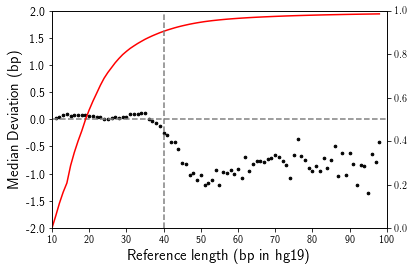

In [14]:
xmax = 100
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(reflen[:-1], diffs, color="black", s=7);
ax.set_xlabel("Reference length (bp in hg19)", size=15)
ax.set_ylabel("Median Deviation (bp)", size=15)
ax.set_ylim(bottom=-2, top=2)
ax.set_xlim(left=10, right=xmax)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.axhline(y=0, linestyle="dashed", color="gray")

ax2 = ax.twinx()
ax2.plot(reflen[:-1], percs, color="red");
ax2.set_ylim(bottom=0, top=1)
ax2.set_xlim(left=10, right=xmax)
ax2.set_xticklabels([int(x) for x in ax.get_xticks()], size=12);
ax2.axvline(x=40, linestyle="dashed", color="gray")

# Stutter

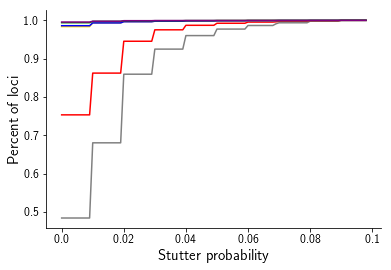

In [15]:
locstats["stutterprob"] = locstats["up"] + locstats["down"]
fig = plt.figure()
ax = fig.add_subplot(111)
bins = np.arange(0, 0.1, 0.001)
for period in range(1, 7):
    x = locstats[(locstats["period"]==period) & (locstats["AN"]>=0) & ~np.isnan(locstats["pgeom"])]
    counts, bins = np.histogram(x["stutterprob"], bins=bins)
    total = sum(counts)
    counts = np.cumsum(counts)
    counts = [item*1.0/total for item in counts]
    ax.plot(bins[:-1], counts, color=colors[period-1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Stutter probability", size=15)
ax.set_ylabel("Percent of loci", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12);

# Calls/sample

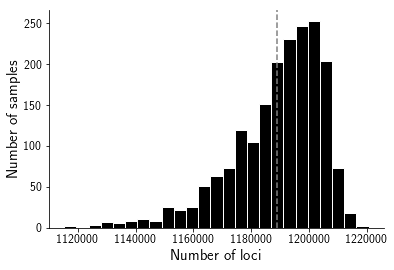

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(sampstats["numloci"], color="black", edgecolor="white", bins=25);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Number of loci", size=15)
ax.set_ylabel("Number of samples", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);
ax.axvline(x=np.mean(sampstats["numloci"]), color="gray", linestyle="dashed")
fig.savefig(os.path.join(OUTPATH, "Figure1_LociPerSample.pdf"))

# Mendelian inheritance

In [10]:
mend = pd.read_csv(os.path.join(TMPPATH, "mend_stats.tab"),
                   names=["chrom","start","sample","Q","DP","mend","homref"], sep="\t", nrows=1000000)
mend["mend"] = mend["mend"].apply(int)
mend["chrom"] = mend["chrom"].apply(str)
mend = pd.merge(mend, hipstr, on=["chrom","start"])
mend = pd.merge(mend, locstats[["chrom","start","end","hrun"]], on=["chrom","start"])
mend = mend[~mend["homref"]]
mend = pd.merge(mend, hiphet, on=["chrom","start"])

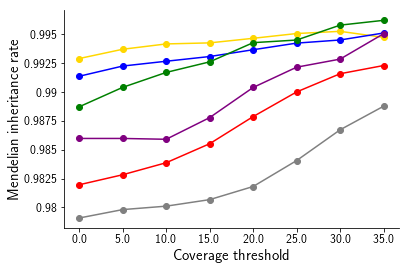

In [25]:
# Mendelian inheritance vs. coverage
fig = plt.figure()
ax = fig.add_subplot(111)
coverages = np.arange(0, 40, 5)

for period in range(1, 7):
    mend_scores = []
    for cov in coverages:
        x = mend[(mend["DP"]>=cov) & (mend["period"]==period)]
        if period >= 5:
            x = x[x["hrun"]<=(period-1)]
        if x.shape[0] >= 50:
            mend_scores.append(np.mean(x["mend"]))
        else: mend_scores.append(np.nan)
    ax.plot(coverages, mend_scores, color=colors[period-1], marker="o");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Coverage threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

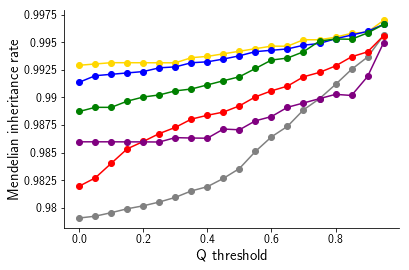

In [26]:
# Mendelian inheritance vs. qual
fig = plt.figure()
ax = fig.add_subplot(111)
scores = np.arange(0.0, 1, 0.05)

for period in range(1, 7):
    mend_scores = []
    for q in scores:
        x = mend[(mend["Q"]>=q) & (mend["period"]==period)]
        if period >= 5:
            x = x[x["hrun"]<=(period-1)]
        if x.shape[0] >= 50:
            mend_scores.append(np.mean(x["mend"]))
        else: mend_scores.append(np.nan)
    ax.plot(scores, mend_scores, color=colors[period-1], marker="o");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Q threshold", size=15)
ax.set_ylabel("Mendelian inheritance rate", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure1_MendInheritance.pdf"))

# Comparison to lobSTR heterozygosities

In [51]:
MAXNFILT=1000
MAXNSKIP=100
MINSAMPLES=1000
lobstr = pd.read_csv(os.path.join(TMPPATH, "lobstr_het_stats.tab"), sep="\t", names=["chrom","start","het_lobstr","numcalls"])
lobstr["chrom"] = lobstr["chrom"].apply(lambda x: str(x[3:]))
lobstr = lobstr[lobstr["numcalls"]>=MINLOB]
hiphet = pd.merge(hiphet, locstats, on=["chrom","start"])
het = pd.merge(lobstr, hiphet, on=["chrom","start"])
het = pd.merge(het, hipstr, on=["chrom","start"])
het = het[(het["NFILT"]<=MAXNFILT) & (het["NSKIP"]<=MAXNSKIP) & (het["numcalls_y"]>=MINSAMPLES)]

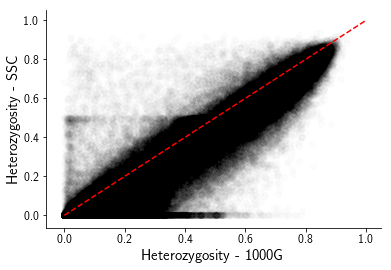

In [63]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = het #[het["cat"]==False]
ax.scatter(x["het_lobstr"], x["het_ssc_length"], color="black", alpha=0.01);
ax.plot([0,1],[0,1], linestyle="dashed", color="red")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Heterozygosity - 1000G", size=15)
ax.set_ylabel("Heterozygosity - SSC", size=15)
ax.set_xticklabels([(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);
#fig.savefig(os.path.join(OUTPATH, "Figure1_Heterozygosities.png"))